In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
import qutip
import numpy as np

In [2]:
from collections import defaultdict
from functools import reduce
from itertools import product
import numpy as np

In [3]:
PAULIS = {"I":np.eye(2, dtype = complex),
          "X":np.array([[0,1],[1,0]], dtype = complex),
          "Y": np.array([[0, -1j],[1j, 0]], dtype = complex),
          "Z": np.array([[1,0],[0,-1]], dtype = complex)}

In [4]:
def compute_meyer_wallach(ket, N):
    ket = qutip.Qobj(ket, dims = [[2]*(N), [1]*(N)]).unit()
    entanglement_sum = 0
    for k in range(N):
        rho_k_sq = ket.ptrace([k])**2
        entanglement_sum += rho_k_sq.tr()
    Q = 2*(1 - (1/N)*entanglement_sum)
    return Q

In [5]:
#n_qubits = 2
#qc = QuantumCircuit(n_qubits)
#qc.h(0)
#qc.h(1)
#qc.z(1)
#out = execute(qc, Aer.get_backend("statevector_simulator")).result().get_statevector()
#Q_value = compute_meyer_wallach(ket=out, N=n_qubits)
#print('Q = %.2f'%(Q_value))

In [6]:
#n_qubits = 2
#qc = QuantumCircuit(n_qubits)
#qc.h(0)
#qc.cx(0,1)
#out = execute(qc, Aer.get_backend("statevector_simulator")).result().get_statevector()
#Q_value = compute_meyer_wallach(out, n_qubits)
#print('Q = %.2f'%(Q_value))

In [7]:
def ansatz(qc, qr, thetas, rounds=3):
    for r in range(rounds):
        for i in range(len(qr)):
            offset = r*len(qr)*2 +i*2
        
            qc.ry(thetas[offset], qr[i])
            qc.rz(thetas[offset+1], qr[i])
            
            if i > 0 and r < rounds - 1:
                qc.cx(qr[i-1], qr[i])
    
    return qc

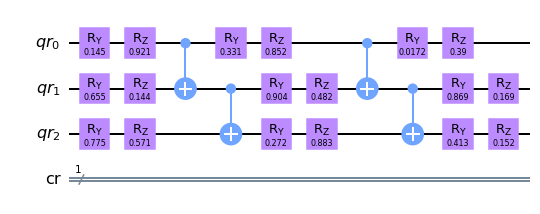

In [8]:
import random
random.seed()
qr = QuantumRegister(3, "qr")
cr = ClassicalRegister(1, "cr")
qc = QuantumCircuit(qr, cr)
rounds = 3
thetas = list(map(lambda x: random.random(), [0]* ((1+rounds)*len(qr)*2)))
ansatz(qc, qr, thetas, rounds=rounds).draw("mpl")

In [9]:
#out = execute(qc,Aer.get_backend('statevector_simulator')).result().get_statevector()
#Q_value = compute_meyer_wallach(ket=out, N=3)
#print('Q = {}\n'.format(round(Q_value, 2)))

In [10]:
def pauli_decomposition(H):
    n = int(np.log2(len(H)))
    dims = 2**n
    
    if H.shape != (dims, dims):
        raise ValueError("The input must be a 2^n x 2^n dimensional matrix.")
        
    basis_key = ["".join(k) for k in product(PAULIS.keys(), repeat = n)]
    components = defaultdict(int)
    
    for i, val in enumerate(product(PAULIS.values(), repeat = n)):
        basis_mat = reduce(np.kron, val)
        coeff = H.reshape(-1).dot(basis_mat.reshape(-1))/dims
        coeff = np.real_if_close(coeff).item()
    
        if not np.allclose(coeff, 0):
            components[basis_key[i]] = coeff
    
    return components

In [11]:
def matrix_decomposition_circuits(H, add_ansatz):
    n = int(np.log2(len(H)))
    dims = 2**n

    if H.shape != (dims, dims):
        raise ValueError("The input must be a 2^n x 2^n dimensional matrix.")

    components = pauli_decomposition(H)

    circuits = {} 
    for (paulistring, weight) in components.items():
        paulis = list(enumerate(reversed(paulistring)))
        qr = QuantumRegister(n, "qr")
        cr = ClassicalRegister(1, "cr")
        qc = QuantumCircuit(qr, cr)
        
        add_ansatz(qc, qr)
        # don't do anything if all Paulis are I
        if all(x[1] == "I" for x in paulis):
            # we use this empty circuit that we will measure as "0" (eigenvalue1) in all cases
            qc.measure(qr[-1], cr[0])
            circuits[paulistring] = (qc, weight)
            continue
            
        # do the single qubit transformations
        for idx, letter in paulis:
            if letter == "X":
                qc.h(qr[idx])
            elif letter == "Y":
                qc.h(qr[idx])
                qc.sdg(qr[idx])
        # add the inter−qubit gates
        for idx, (first, second) in enumerate(zip(paulis, paulis[1:])):
            if second[1] == "I":
                qc.swap(first[0], second[0])
            elif first[1] != "I":
                paulis[idx+1] = (paulis[idx+1][0], paulis[idx][1])
                qc.cx(first[0], second[0])
        # measure the highest qubit
        qc.measure(qr[-1], cr[0])
        circuits[paulistring] = (qc,weight)
        
    return circuits

In [12]:
def run_circuit(circuit, backend, shots = 1000):
    result = execute(circuit, backend, shots = shots).result()
    counts = result.get_counts()
    if "0" in counts.keys():
        count_0 = counts["0"]
    else:
        count_0 = 0
    if "1" in counts.keys():
        count_1 = counts["1"]
    else:
        count_1 = 1
    return (count_0 - count_1)/shots

def expectation(H, rounds, thetas):
    backend = Aer.get_backend("qasm_simulator")
    circuits = matrix_decomposition_circuits(H, lambda qc, qr: ansatz(qc, qr, thetas, rounds))
    
    return sum(map(lambda key: run_circuit(circuits[key][0], backend)*circuits[key][1], circuits.keys()))

In [13]:
class SPSA:
    def __init__(self, a, c, A, alpha, gamma, H, loss_function):
    # Initialize gain parameters and decay factors
        self.a = a
        self.c = c
        self.A = A
        self.alpha = alpha
        self.gamma = gamma
        self.loss_function = loss_function

    # counters
        self.t = 0

    def step(self, current_estimate):
    # get the current values for gain sequences
        a_t = self.a / (self.t + 1 + self.A)**self.alpha
        c_t = self.c / (self.t + 1)**self.gamma

    # get the random perturbation vector from bernoulli distribution
        delta = np.random.randint(0,2, np.array(current_estimate).shape) * 2 - 1

    # measure the loss function at perturbations
        loss_plus = self.loss_function(current_estimate + delta * c_t)
        loss_minus = self.loss_function(current_estimate - delta * c_t)
        
    # compute the estimate of the gradient
        g_t = (loss_plus - loss_minus) / (2.0 * delta * c_t)
    
    # update the estimate of the parameter
        current_estimate = current_estimate - a_t * g_t

     # increment the counter
        self.t += 1

        return current_estimate

In [14]:
def vqe(H, rounds, max_iter, thetas=None, save_steps=None):
    cnt_qubits = int(np.log2(len(H)))
    if thetas is None:
        thetas = list(map(lambda x: random.random(),[0] * ((1+rounds)*cnt_qubits*2)))
    # create the optimizer class
    optimizer = SPSA(a=0.9,c=1.0,A=max_iter/10,alpha=0.6,gamma=0.1,H=H,
                     loss_function=lambda t_thetas: expectation(H, rounds, t_thetas))
    
    # the main loop
    for i in range(max_iter):
        thetas = optimizer.step(thetas)

        if save_steps is not None and i % save_steps == 0:
            yield (i, thetas, expectation(H, rounds, thetas))
            
    return (thetas, expectation(H, rounds, thetas))

In [18]:
H = np.array([[3, 1],[1, 2]],dtype=complex)

result = None
step_size = 3
for step in vqe(H, rounds=4, max_iter=60, save_steps=step_size):
    print('Step {step}. Current expectation value: {ev: .3f}'.format(step=step[0], ev=step[2]))
    result = step

print('The solution is: [\n'+"".join(["\t"+str(round(t, 3))+",\n" if i%3 == 2 else "\t"+str(round(t, 3))
                                      +",\t" for i, t in enumerate(result[1])])+"]")
print('The lowest expectation value is: {ev: .3f}'.format(ev=result[2]))

Step 0. Current expectation value: -1.290
Step 3. Current expectation value: -3.090
Step 6. Current expectation value: -2.995
Step 9. Current expectation value: -3.044
Step 12. Current expectation value: -2.953
Step 15. Current expectation value: -3.037
Step 18. Current expectation value: -3.050
Step 21. Current expectation value: -2.521
Step 24. Current expectation value: -2.736
Step 27. Current expectation value: -2.874
Step 30. Current expectation value: -2.927
Step 33. Current expectation value: -2.799
Step 36. Current expectation value: -3.052
Step 39. Current expectation value: -2.956
Step 42. Current expectation value: -2.181
Step 45. Current expectation value: -3.037
Step 48. Current expectation value: -3.061
Step 51. Current expectation value: -2.449
Step 54. Current expectation value: -2.969
Step 57. Current expectation value: -2.571
The solution is: [
	0.888,		1.129,		2.567,
	-1.326,		0.294,		1.295,
	0.723,		1.312,		-0.178,
	-1.276,	]
The lowest expectation value is: -2.571


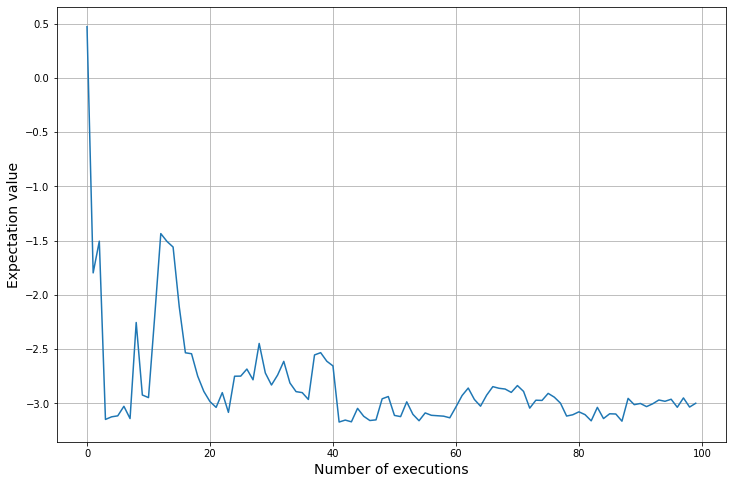

In [17]:
import matplotlib.pyplot as plt

steps = []
evs = []
for step in vqe(H, rounds=4, max_iter=100, save_steps=1):
    steps = steps + [step[2]]
    evs = evs + [step[0]]

plt.figure(figsize=(12, 8))
plt.plot(evs, steps)

plt.xlabel("Number of executions", fontsize=14)
plt.ylabel("Expectation value", fontsize=14)
plt.grid()

plt.show()